The purpose of this notebook is to create a set of graphs from the course descriptions : the graph related to professors, assistants and study plans. 

## Import the libraries :

In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
import re
import networkx as nx
import itertools
from pygsp import graphs, filters, plotting
from sklearn.cluster import KMeans
from sklearn import metrics
import pickle
import os
from collections import Counter

from sklearn import mixture

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

The dictionnaries built in this notebook are :
* students_courses_dico : dictionnary which links the PersonIDs (students IDs) to the courses the persons took (but indirect link)
* courses_index_dico : dictonnary which links the courses IDs to integers (used in all the notebook)
* section_courses_dico: dictionnary which links the study plans to the courses they contain
* prof_courses_dico : dictionnary which links the professors to the courses they teach
* assistants_courses_dico : dictionnary which links the assistants to the courses they assist

In [2]:
A_FEW_SECTIONS=True # True if you want to keep only a few sections, False to keep all sections

## 3 Graph with respect to what the students chose

## 3.0 Load the data

In [3]:
if A_FEW_SECTIONS:
    enrol2=pd.read_pickle("../data/cleaned_enrol_STI.pickle")
    courses=pd.read_pickle("../data/cleaned_courses_STI.pickle")
    string='STI'
else:
    enrol2=pd.read_pickle("../data/cleaned_enrol.pickle")
    courses=pd.read_pickle("../data/cleaned_courses.pickle")
    string='with_AR'
    
years=pd.read_pickle(os.path.join("Graphs","years.pkl"))

## 3.1 See what we have:

In [4]:
# See what it remains
Students=enrol2['PersonID'].unique() # The different students
Courses=enrol2['CourseCodes'].unique() # The different courses : USED in the the next part !!!
print('There are {} students in the dataset'.format(len(Students)))
print('There are {} different courses in the dataset'.format(len(Courses)))
enrol2['StudyPlanCode'].unique() # See which section it remains:

There are 5715 students in the dataset
There are 196 different courses in the dataset


array(['MA1', 'MA3', 'MA2', 'MA4'], dtype=object)

## 3.2 Build a dictionary linking students to their courses:

In [5]:
# dictionnary of students and their courses:
students_courses_df=enrol2[['PersonID','CourseCodes']].set_index('PersonID')
students_courses_dico=students_courses_df.groupby(students_courses_df.index).apply(lambda x: x.to_dict('list'))

# dictionnary of courses and their indices:
courses_index_dico=dict(zip(Courses, np.arange(len(Courses)))) # dictionnary to link a course code to a number, USED in the
# following part !!!

## 3.3 Build the weight matrix

In [6]:
weights_wt_students=np.zeros((len(Courses),len(Courses))) # weight matrix 1

In [7]:
w1=0.1 # weight for each edge

for person in Students: # for each student ...
    for course1, course2 in itertools.combinations(students_courses_dico[person]['CourseCodes'], 2):
        nb_years=min(years[course1], years[course2])
        weights_wt_students[courses_index_dico[course1],courses_index_dico[course2]]+=(w1/nb_years) # add a weight between the courses
        weights_wt_students[courses_index_dico[course2],courses_index_dico[course1]]+=(w1/nb_years) # add a weight between the courses


Check the matrix is symmetric:

In [8]:
np.nonzero(weights_wt_students-weights_wt_students.T)

(array([], dtype=int64), array([], dtype=int64))

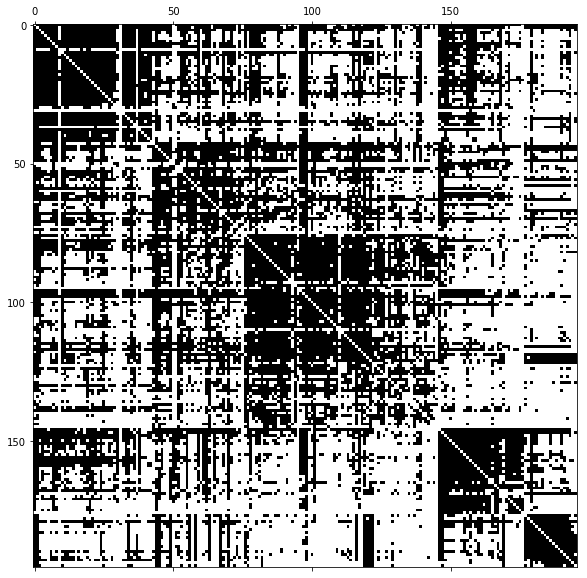

In [9]:
plt.figure(1,figsize=(10,10))
plt.spy(weights_wt_students)

## 3.4 Visualize the graph

In [10]:
G1=nx.from_numpy_matrix(weights_wt_students)

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


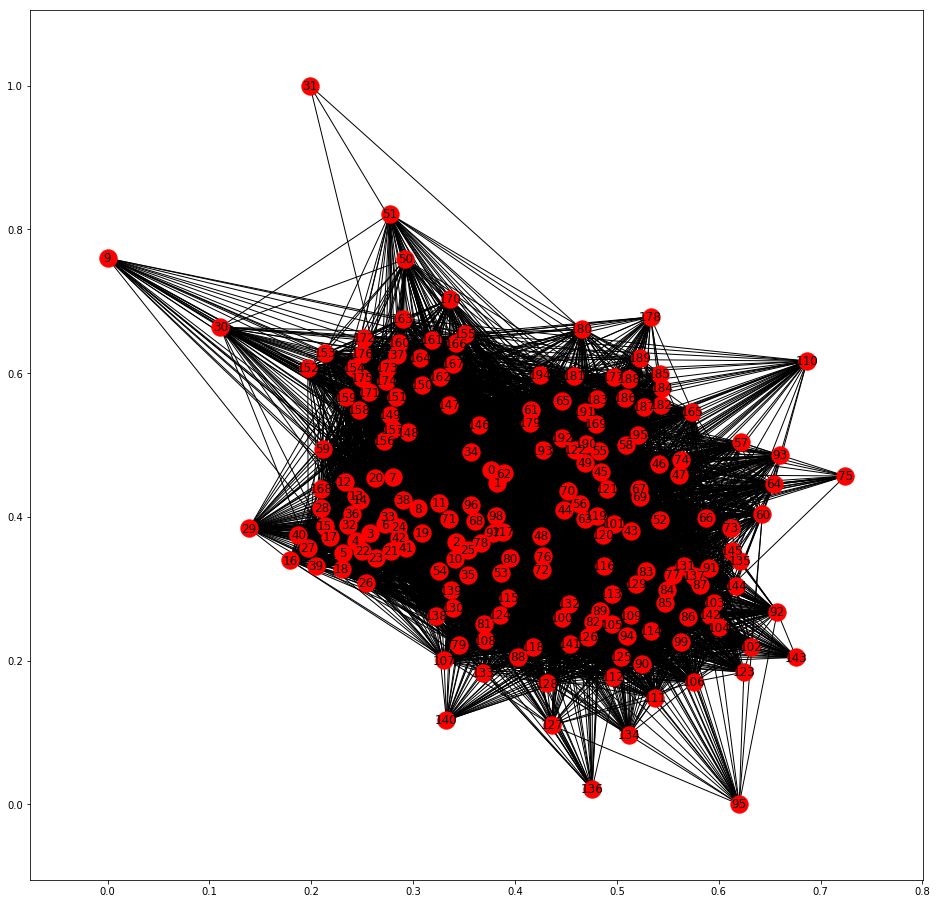

In [11]:
plt.figure(1,figsize=(16,16)) 
pos1 = nx.spring_layout(G1)
nx.draw_networkx_nodes(G1, pos1, cmap=plt.get_cmap('jet')) # plot the nodes
nx.draw_networkx_labels(G1, pos1) # plot the labels
nx.draw_networkx_edges(G1, pos1) # plot the edges
plt.show()

In [12]:
len(list(nx.connected_component_subgraphs(G1))) # number of connected components

1

(array([  2.,  12.,  23.,  33.,  40.,  32.,  24.,  17.,   9.,   4.]),
 array([   3. ,   20.7,   38.4,   56.1,   73.8,   91.5,  109.2,  126.9,
         144.6,  162.3,  180. ]),
 <a list of 10 Patch objects>)

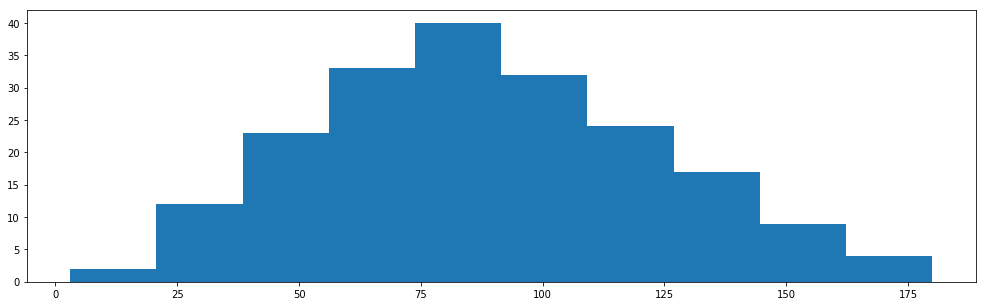

In [13]:
plt.hist(list(nx.degree(G1).values())) # degree distribution

In [14]:
hub_student=np.argmax(list(nx.degree(G1).values()))
print('The hub is:')
print(Courses[hub_student])
print(courses[courses.index.str.endswith(Courses[hub_student])].CourseTitleFR.tolist()[0])

The hub is:
EE-585
Space mission design and operations


In [15]:
# Save the weight matrix in a .pkl file:
pkl_file = open(os.path.join(os.getcwd(),"Graphs","students_graph_"+str(string)+".pkl"), "wb")
pickle.dump(weights_wt_students, pkl_file)
pkl_file.close()

## 4  Graph with respect to the sections

## 4.1  Remove/drop the PDM, CMS, propédeutique, SHS, internship, project:

In [16]:
courses2=courses[courses.index.isin(Courses)]

## 4.2 Build a dictionary linking each section to its related courses

In [17]:
# Identify the study plan:
dump=courses2['StudyPlans'].str.replace(' -','').str.replace(r'^ ','').str.replace(r' $','').str.replace(' ;',';').str.replace('; ',';')
dump=dump.str.split(';',expand=True)
StudyPlans=[]
for i in range(9): #10 vs 9
    StudyPlans+=dump[i].unique().tolist()
StudyPlans = sorted(list(set(list(filter(None,StudyPlans)))))
# remove elements beggining with ED, Ho, Au or UN:
StudyPlans=[elem for elem in StudyPlans if elem[:2] !='ED' and elem[:2]!='Ho' and elem[:2]!='Au' and elem[:2]!='UN']        
print(len(StudyPlans))

27


In [18]:
# Build the dictionnary wrt to sections:
section_courses_dico={}

for plan in StudyPlans:
    section_courses_dico[plan]=courses2[courses2['StudyPlans'].str.contains(plan)].index.tolist()

## 4.4 Build the weight matrix

In [19]:
weights_wt_section=np.zeros((len(Courses),len(Courses))) # weight matrix 2

NB: "Courses" should be the list of the currently existing courses

In [20]:
w2=0.1 # weight for each edge

for plan in StudyPlans: # for each study plan ...
    for course1, course2 in itertools.combinations(section_courses_dico[plan], 2):
        weights_wt_section[courses_index_dico[course1],courses_index_dico[course2]]+=w2 # add a weight between the courses
        weights_wt_section[courses_index_dico[course2],courses_index_dico[course1]]+=w2 # add a weight between the courses

Check the matrix is symmetric:

In [21]:
np.nonzero(weights_wt_section-weights_wt_section.T)

(array([], dtype=int64), array([], dtype=int64))

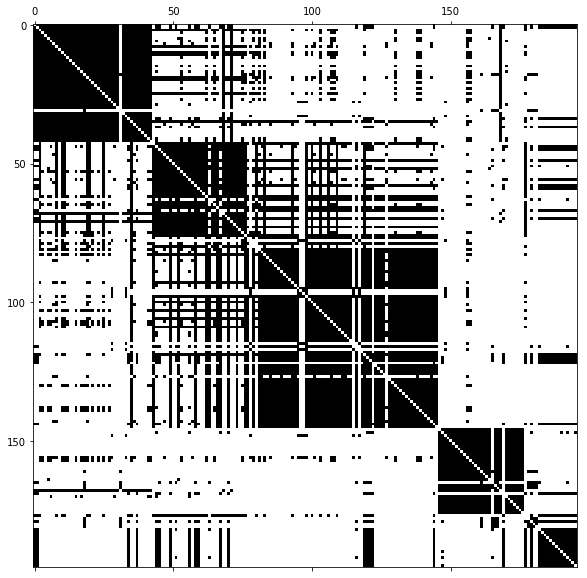

In [22]:
plt.figure(1,figsize=(10,10))
plt.spy(weights_wt_section)

## 4.5 Visualize the graph

In [23]:
G2=nx.from_numpy_matrix(weights_wt_section)

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


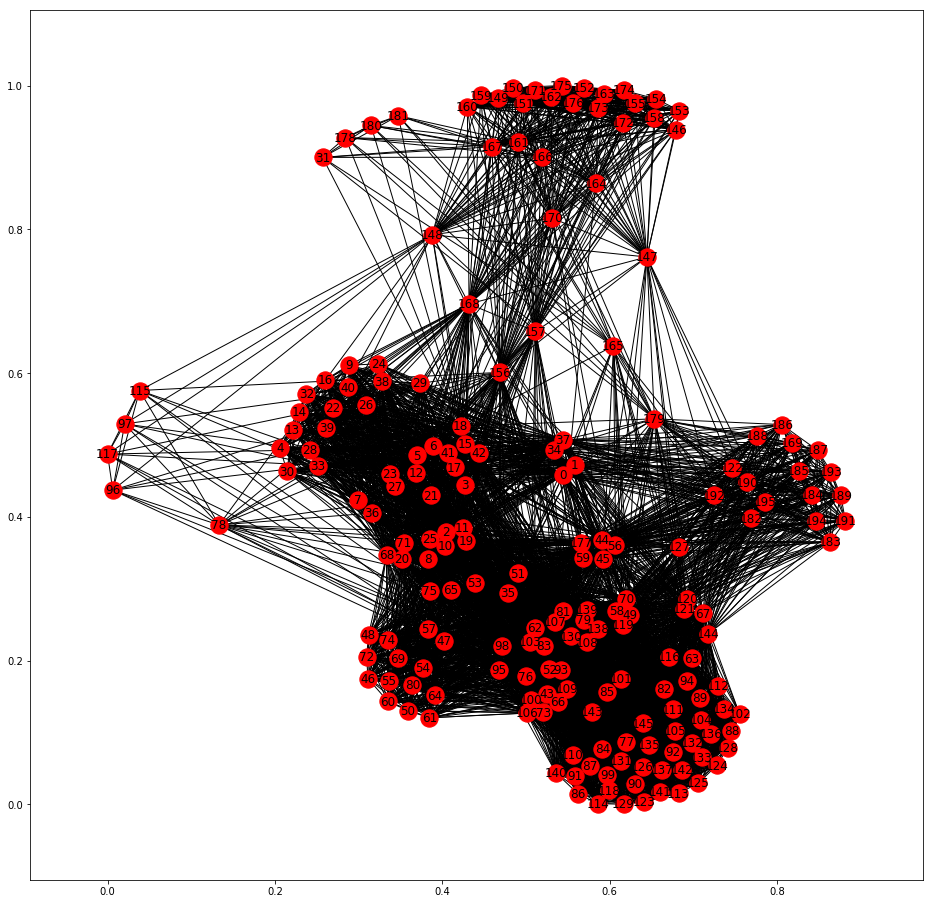

In [24]:
plt.figure(1,figsize=(16,16)) 
pos2 = nx.spring_layout(G2)
nx.draw_networkx_nodes(G2, pos2, cmap=plt.get_cmap('jet')) # plot the nodes
nx.draw_networkx_labels(G2, pos2) # plot the labels
nx.draw_networkx_edges(G2, pos2) # plot the edges
plt.show()

In [25]:
len(list(nx.connected_component_subgraphs(G2))) # number of connected components

1

(array([  9.,  39.,  20.,  31.,  46.,  14.,  19.,  10.,   7.,   1.]),
 array([   9. ,   22.3,   35.6,   48.9,   62.2,   75.5,   88.8,  102.1,
         115.4,  128.7,  142. ]),
 <a list of 10 Patch objects>)

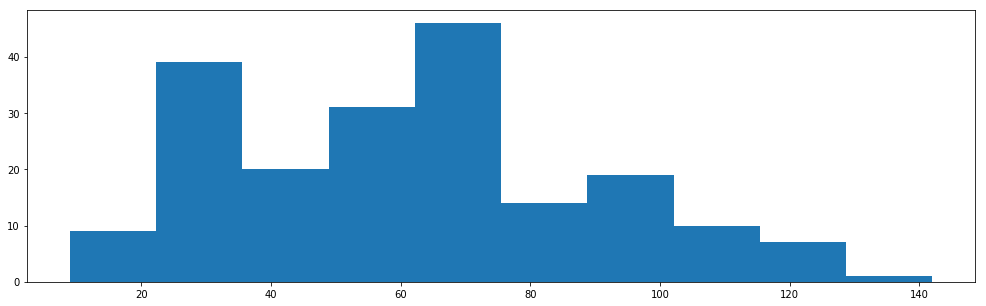

In [26]:
plt.hist(list(nx.degree(G2).values())) # degree distribution

In [27]:
hub_section=np.argmax(list(nx.degree(G2).values()))
print('The hub is:')
print(Courses[hub_section])
print(courses[courses.index.str.endswith(Courses[hub_section])].CourseTitleFR.tolist()[0])

The hub is:
ME-425
Model predictive control


In [28]:
# Save the weight matrix in a .pkl file
pkl_file = open(os.path.join(os.getcwd(),"Graphs","section_graph_"+str(string)+".pkl"), "wb")
pickle.dump(weights_wt_section, pkl_file)
pkl_file.close()

# 5  Graph with respect to the professors

## 5.1 Clean the courses to always have a teacher

In [29]:
ind3=np.where(courses2.ProfessorSCIPERs.isnull())[0]
courses3=courses2.drop(courses2.index[ind3])

Prof=courses3['ProfessorSCIPERs'].unique()
CoursesCodes=courses3.index.unique()
print('There are {} professors in the dataset'.format(len(Prof)))
print('There are {} different courses in the dataset'.format(len(CoursesCodes)))

There are 158 professors in the dataset
There are 192 different courses in the dataset


## 5.2 Separate the professors' scipers when needed

In [30]:
Prof_scipers=[Prof[i].split(';') for i in range(len(Prof))]
Prof_scipers = list(set(itertools.chain.from_iterable(Prof_scipers)))
print('There are {} different professors in the dataset'.format(len(Prof_scipers)))

There are 172 different professors in the dataset


## 5.3 Build a dictionary linking each professor to the courses they teach

In [31]:
prof_courses_dico={}

for prof_sci in Prof_scipers:
    prof_courses_dico[prof_sci]=courses3[courses3['ProfessorSCIPERs'].str.contains(prof_sci)].index.tolist()

## 5.4 Build the weight matrix

In [32]:
weights_wrt_prof=np.zeros((len(Courses),len(Courses))) # weight matrix 3

In [33]:
w3=0.1 # weight for each edge

for prof_sci in Prof_scipers: # for each prof ...
    for course1, course2 in itertools.combinations(prof_courses_dico[prof_sci], 2):
        weights_wrt_prof[courses_index_dico[course1],courses_index_dico[course2]]+=w3 # add a weight between the courses
        weights_wrt_prof[courses_index_dico[course2],courses_index_dico[course1]]+=w3 # add a weight between the courses

In [34]:
# Check the matrix is symmetric:
np.nonzero(weights_wrt_prof-weights_wrt_prof.T)

(array([], dtype=int64), array([], dtype=int64))

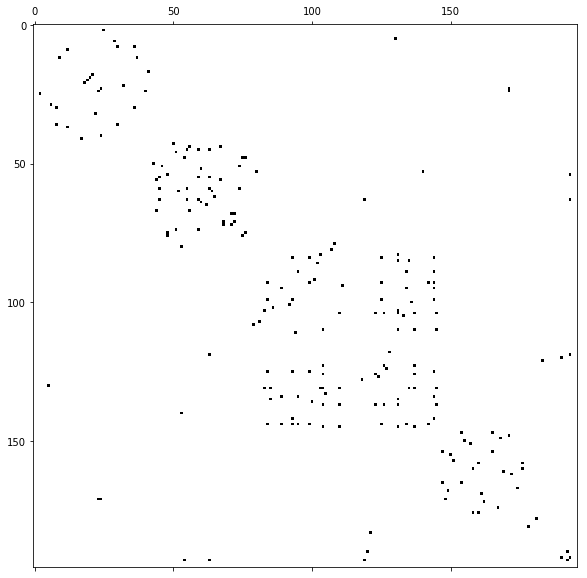

In [35]:
plt.figure(1,figsize=(10,10))
plt.spy(weights_wrt_prof)

## 5.5 Visualize the graph

In [36]:
G3=nx.from_numpy_matrix(weights_wrt_prof)

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


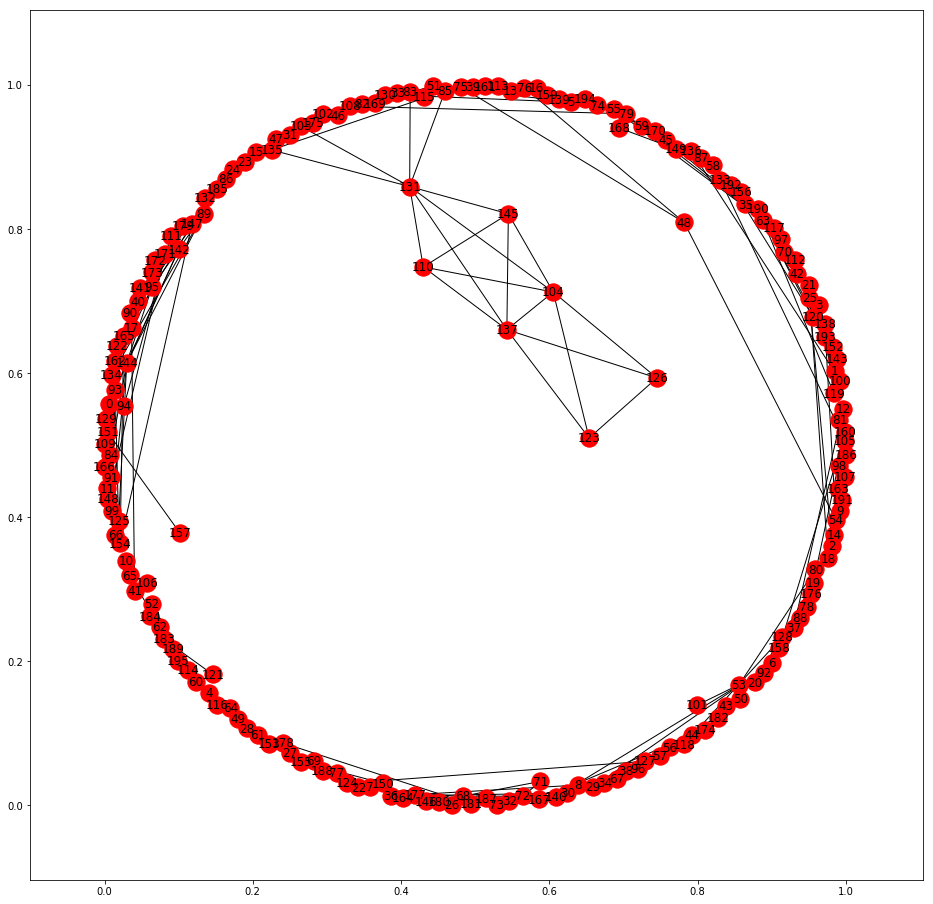

In [37]:
plt.figure(1,figsize=(16,16)) 
pos3 = nx.spring_layout(G3)
nx.draw_networkx_nodes(G3, pos3, cmap=plt.get_cmap('jet')) # plot the nodes
nx.draw_networkx_labels(G3, pos3) # plot the labels
nx.draw_networkx_edges(G3, pos3) # plot the edges
plt.show()

In [38]:
len(list(nx.connected_component_subgraphs(G3))) # number of connected components

117

In [39]:
Gcc=sorted(nx.connected_component_subgraphs(G3), key = len, reverse=True)[0]
print(len(Gcc)) # size of the giant component
print(list(Gcc)) # list of the nodes of the giant components

16
[192, 193, 74, 75, 76, 45, 46, 48, 51, 119, 54, 55, 120, 59, 190, 63]


In [40]:
print(Courses[Gcc]) # course codes of the giant components
print([courses2[courses2.index.str.endswith(Courses[Gcc][p])].CourseTitleFR.tolist() for p in range(len(Gcc))])

['BIOENG-486' 'BIOENG-404' 'MICRO-530' 'MICRO-570' 'MICRO-455' 'MICRO-560'
 'MICRO-431' 'MICRO-453' 'MICRO-331' 'EE-511' 'MICRO-452' 'MICRO-430'
 'EE-514' 'MICRO-330' 'BIOENG-448' 'MICRO-568']
[['Sensorimotor neuroprosthetics'], ['Analysis and modelling of locomotion'], ['Nanotechnology'], ['Advanced machine learning'], ['Applied machine learning'], ['BioMEMS'], ['Materials and technology of microfabrication'], ['Robotics practicals'], ['Technologie des microstructures I'], ['Sensors in medical instrumentation'], ['Mobile robots'], ['Scaling laws in micro- and nanosystems'], ['Brain computer interaction'], ['Capteurs'], ['Fundamentals of neuroengineering'], ['Seminar in physiology and instrumentation']]


In [41]:
print(list(nx.connected_components(G3))) # display the different components

[{0}, {1}, {25, 2}, {3}, {4}, {130, 5}, {29, 6}, {7}, {8, 36, 30}, {9, 12, 37}, {10}, {11}, {13}, {14}, {15}, {16}, {17, 41}, {18, 21}, {19, 20}, {32, 22}, {40, 171, 148, 23, 24}, {26}, {27}, {28}, {31}, {33}, {34}, {35}, {38}, {39}, {42}, {50, 43}, {56, 67, 44}, {192, 193, 74, 75, 76, 45, 46, 48, 51, 119, 54, 55, 120, 59, 190, 63}, {47}, {49}, {64, 52, 60}, {80, 140, 53}, {57}, {58}, {61}, {65, 62}, {66}, {72, 68, 71}, {69}, {70}, {73}, {77}, {78}, {108, 79}, {81, 107}, {82}, {131, 135, 104, 103, 137, 110, 145, 83, 85, 123, 126}, {99, 134, 142, 144, 84, 125, 89, 93, 95}, {102, 86}, {87}, {88}, {90}, {91}, {92, 101}, {94, 111}, {96}, {97}, {98}, {136, 100}, {105, 133}, {106}, {109}, {112}, {113}, {114}, {115}, {116}, {117}, {128, 118}, {121, 183}, {122}, {124, 127}, {129}, {132}, {138}, {139}, {141}, {143}, {146}, {154, 147, 165}, {168, 149}, {155, 150}, {157, 151}, {152}, {153}, {156}, {160, 158, 176}, {159}, {161, 169}, {162, 172}, {163}, {164}, {166}, {174, 167}, {170}, {173}, {175}

(array([ 105.,    8.,    1.,    0.,    0.,    1.,    1.,    0.,    0.,    1.]),
 array([  1. ,   2.5,   4. ,   5.5,   7. ,   8.5,  10. ,  11.5,  13. ,
         14.5,  16. ]),
 <a list of 10 Patch objects>)

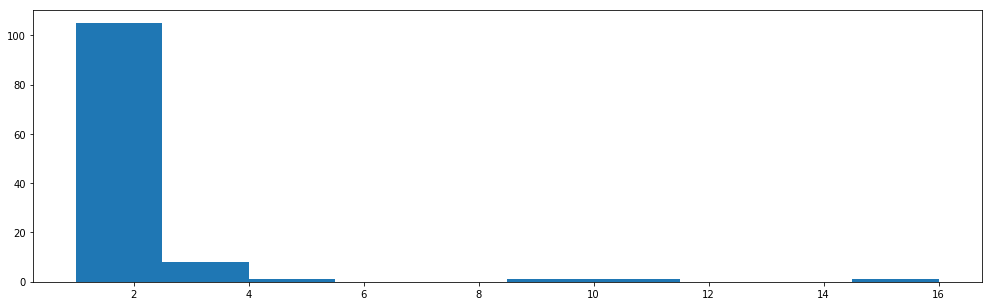

In [42]:
# distribution of the sizes of the connected components:
plt.hist([len(list(nx.connected_components(G3))[p]) for p in range(len(list(nx.connected_component_subgraphs(G3))))])

(array([ 79.,  62.,  32.,  10.,   0.,   7.,   2.,   2.,   0.,   2.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ]),
 <a list of 10 Patch objects>)

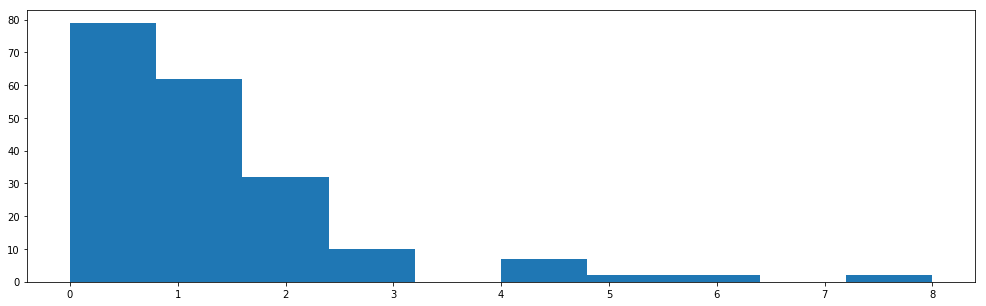

In [43]:
plt.hist(list(nx.degree(G3).values())) # degree distribution

In [44]:
hub_prof=np.argmax(list(nx.degree(G3).values()))
print('The hub is:')
print(Courses[hub_prof])
print(courses[courses.index.str.endswith(Courses[hub_prof])].CourseTitleFR.tolist()[0])
print('The neighbors of this hub are:')
ind_hub_prof=np.where(weights_wrt_prof[hub_prof,:]>0)[0]
print(Courses[ind_hub_prof])
print([courses[courses.index.str.endswith(Courses[ind_hub_prof][p])].CourseTitleFR.tolist() for p in range(len(ind_hub_prof))])

The hub is:
EE-490(b)
Lab in EDA based design
The neighbors of this hub are:
['EE-420' 'EE-432' 'EE-421' 'EE-431' 'EE-330' 'EE-434' 'EE-429' 'EE-428']
[['Analog circuits design I'], ['Hardware systems modeling I'], ['Analog circuits design II'], ['Advanced VLSI design'], ['IC design II'], ['Hardware systems modeling'], ['Fundamentals of VLSI design'], ['Introduction to VLSI Design']]


In [45]:
# Save the weight matrix in a .pkl file:
pkl_file = open(os.path.join(os.getcwd(),"Graphs","prof_graph_"+str(string)+".pkl"), "wb")
pickle.dump(weights_wrt_prof, pkl_file)
pkl_file.close()

## 6 Graph with respect to the assistants

## 6.1 Clean the courses to always have an assistant

In [46]:
ind2=np.where(courses2.AssistantSCIPERs.isnull())[0]
courses4=courses2.drop(courses2.index[ind2])

Assistants=courses4['AssistantSCIPERs'].unique()
CoursesCodes=courses4.index.unique()
print('There are {} assistants in the dataset'.format(len(Assistants)))
print('There are {} different courses in the dataset'.format(len(CoursesCodes)))

There are 57 assistants in the dataset
There are 57 different courses in the dataset


## 6.2 Separate the professors' scipers when needed

In [47]:
Assistant_scipers=[Assistants[i].split(';') for i in range(len(Assistants))]
Assistant_scipers = list(set(itertools.chain.from_iterable(Assistant_scipers)))
print('There are {} different assistants in the dataset'.format(len(Assistant_scipers)))

There are 125 different assistants in the dataset


## 6.3 Build a dictionary linking each assistant to the courses they teach

In [48]:
assistants_courses_dico={}

for ass_sci in Assistant_scipers:
    assistants_courses_dico[ass_sci]=courses4[courses4['AssistantSCIPERs'].str.contains(ass_sci)].index.tolist()

## 6.4 Build the weight matrix

In [49]:
weights_wrt_assistants=np.zeros((len(Courses),len(Courses))) # weight matrix 4

In [50]:
w4=0.1 # weight for each edge

for ass_sci in Assistant_scipers: # for each prof ...
    for course1, course2 in itertools.combinations(assistants_courses_dico[ass_sci], 2):
        weights_wrt_assistants[courses_index_dico[course1],courses_index_dico[course2]]+=w4 # add a weight between the courses
        weights_wrt_assistants[courses_index_dico[course2],courses_index_dico[course1]]+=w4 # add a weight between the courses

In [51]:
np.nonzero(weights_wrt_assistants-weights_wrt_assistants.T)

(array([], dtype=int64), array([], dtype=int64))

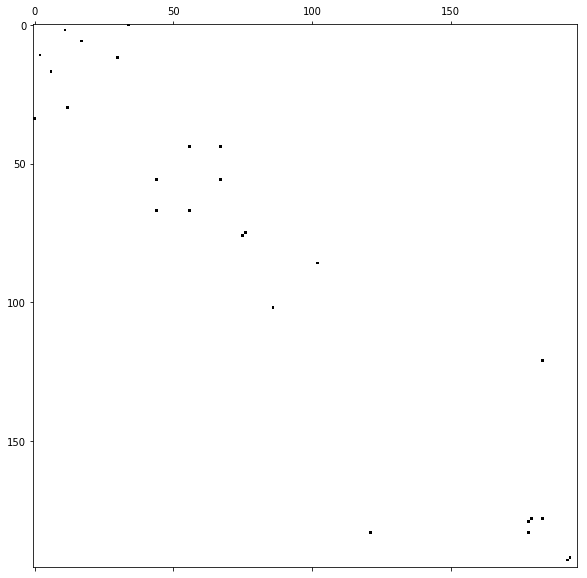

In [52]:
plt.figure(1,figsize=(10,10))
plt.spy(weights_wrt_assistants)

## 6.6 Visualize the graph

In [53]:
G4=nx.from_numpy_matrix(weights_wrt_assistants)

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


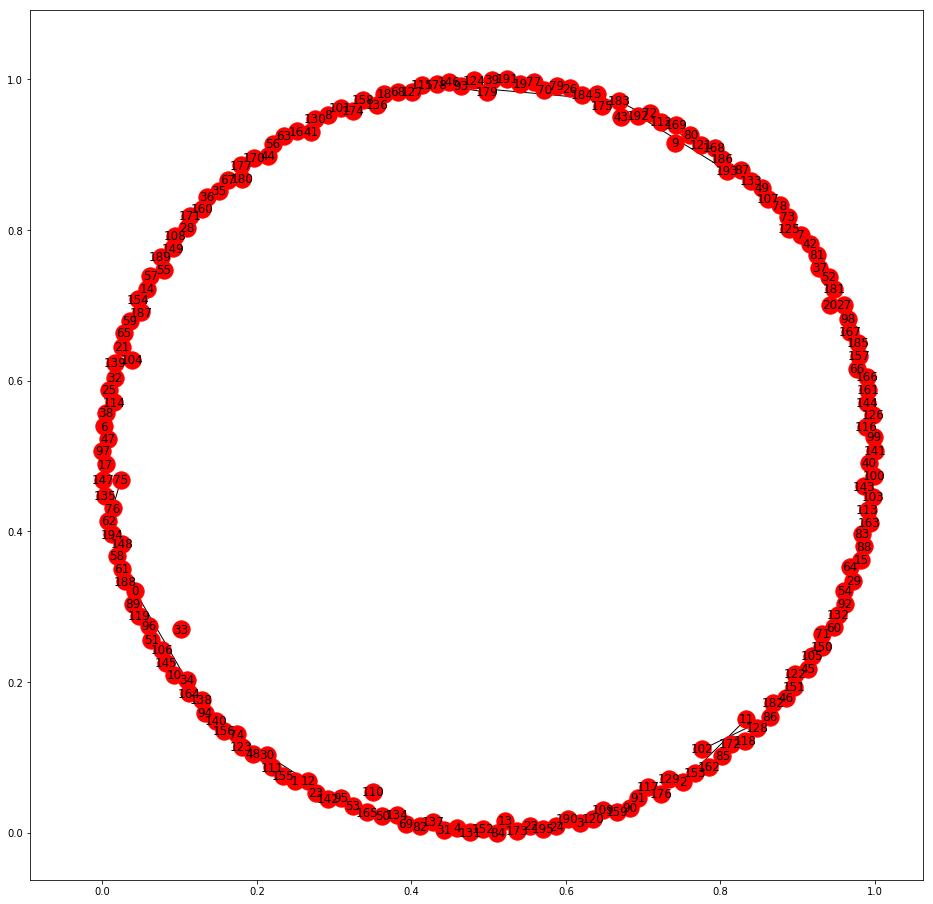

In [54]:
plt.figure(1,figsize=(16,16)) 
pos4 = nx.spring_layout(G4)
nx.draw_networkx_nodes(G4, pos4, cmap=plt.get_cmap('jet')) # plot the nodes
nx.draw_networkx_labels(G4, pos4) # plot the labels
nx.draw_networkx_edges(G4, pos4) # plot the edges
plt.show()

In [55]:
len(list(nx.connected_component_subgraphs(G4))) # number of connected components

184

In [56]:
Gcc=sorted(nx.connected_component_subgraphs(G4), key = len, reverse=True)[0]
print(len(Gcc)) # size of the giant component
list(Gcc) # nodes of the giant component

4


[121, 178, 179, 183]

(array([ 175.,    0.,    0.,    7.,    0.,    0.,    1.,    0.,    0.,    1.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

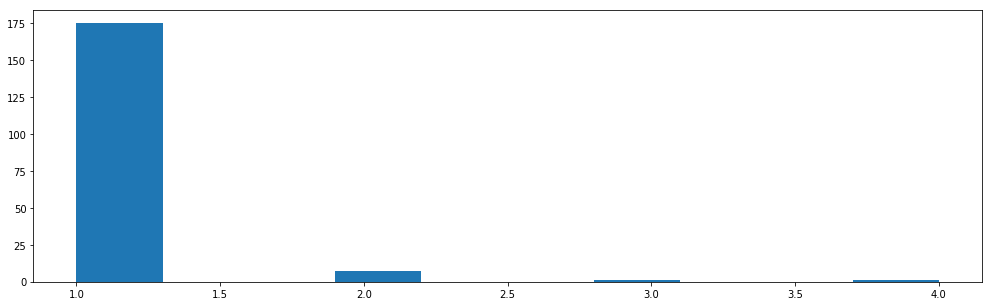

In [57]:
# distribution of the sizes of the connected components:
plt.hist([len(list(nx.connected_components(G4))[p]) for p in range(len(list(nx.connected_component_subgraphs(G4))))])

(array([ 175.,    0.,    0.,    0.,    0.,   16.,    0.,    0.,    0.,    5.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

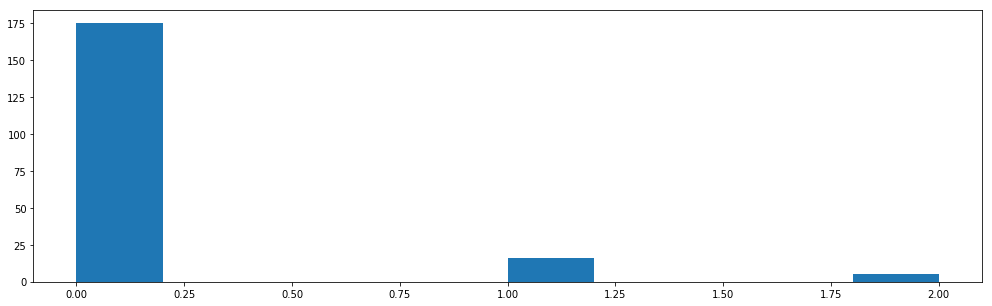

In [58]:
plt.hist(list(nx.degree(G4).values())) # degree distribution

In [59]:
hub_assistant=np.argmax(list(nx.degree(G4).values()))
print('The hub is:')
print(Courses[hub_assistant])
print(courses[courses.index.str.endswith(Courses[hub_assistant])].CourseTitleFR.tolist()[0])
print('The neighbors of this hub are:')
ind_hub_assistants=np.where(weights_wrt_assistants[hub_assistant,:]>0)[0]
print(Courses[ind_hub_assistants])
print([courses[courses.index.str.endswith(Courses[ind_hub_assistants][p])].CourseTitleFR.tolist() for p in range(len(ind_hub_assistants))])

The hub is:
MICRO-511
Image processing I
The neighbors of this hub are:
['MICRO-512' 'MICRO-513']
[['Image processing II'], ['Signal processing for functional brain imaging']]


In [60]:
# Save the weight matrix in a .pkl file:
pkl_file = open(os.path.join(os.getcwd(),"Graphs","assistants_graph_"+str(string)+".pkl"), "wb")
pickle.dump(weights_wrt_assistants, pkl_file)
pkl_file.close()